In [ ]:
import numpy as np
from pathlib import Path
from dataclasses import dataclass
from typing import Optional, List


@dataclass
class DatasetPredictions:
    ground_truth: np.ndarray  # (n_samples, horizon, n_feats)
    TimeXer_preds: Optional[np.ndarray] = None
    TimesNet_preds: Optional[np.ndarray] = None
    TimeMixer_preds: Optional[np.ndarray] = None
    PatchTST_preds: Optional[np.ndarray] = None
    iTransformer_preds: Optional[np.ndarray] = None
    DLinear_preds: Optional[np.ndarray] = None
    Crossformer_preds: Optional[np.ndarray] = None


@dataclass
class ClassificationDataset:
    inputs: np.ndarray      # (n_valid, lookback, n_feats)
    mse: np.ndarray         # (n_valid, n_models)
    labels: np.ndarray      # (n_valid, n_models), 1=best, 0=otherwise
    model_names: List[str]  # list of model names in order


def load_model_predictions(
    dataset_name: str,
    results_dir: str | Path = "/Users/eiriksteen/Personal/research/virginia/code/tsrouter/results"
) -> DatasetPredictions:
    """
    Load predictions for all seven models and ground truth.
    """
    results_path = Path(results_dir)
    models = ['TimeXer', 'TimesNet', 'TimeMixer',
              'PatchTST', 'iTransformer', 'DLinear', 'Crossformer']

    predictions = {}
    ground_truth = None

    for model in models:
        pattern = f"long_term_forecast_{dataset_name}_96_96_{model}_"
        matching_dirs = [d for d in results_path.iterdir()
                         if d.is_dir() and d.name.startswith(pattern)]

        if matching_dirs:
            model_dir = matching_dirs[0]
            pred_file = model_dir / "pred.npy"
            true_file = model_dir / "true.npy"

            if pred_file.exists():
                predictions[model] = np.load(pred_file)
            else:
                predictions[model] = None

            if ground_truth is None and true_file.exists():
                ground_truth = np.load(true_file)
        else:
            predictions[model] = None

    return DatasetPredictions(
        ground_truth=ground_truth,
        TimeXer_preds=predictions.get('TimeXer'),
        TimesNet_preds=predictions.get('TimesNet'),
        TimeMixer_preds=predictions.get('TimeMixer'),
        PatchTST_preds=predictions.get('PatchTST'),
        iTransformer_preds=predictions.get('iTransformer'),
        DLinear_preds=predictions.get('DLinear'),
        Crossformer_preds=predictions.get('Crossformer')
    )


def create_classification_dataset(
    data: DatasetPredictions,
    window_size: int = 96
) -> ClassificationDataset:
    gt = data.ground_truth  # (n_samples, window_size, n_feats)
    n_samples, ws, n_feats = gt.shape
    if ws != window_size:
        raise ValueError(f"Expected window_size={window_size}, got {ws}")

    if n_samples < 2:
        raise ValueError("Need at least 2 windows")

    model_names = ['TimeXer', 'TimesNet', 'TimeMixer', 'PatchTST',
                   'iTransformer', 'DLinear', 'Crossformer']
    n_models = len(model_names)

    # --- Compute MSE on *next* window ---
    mse_next = np.full((n_samples - 1, n_models), np.inf, dtype=np.float32)
    for i, name in enumerate(model_names):
        preds = getattr(data, f"{name}_preds")
        if preds is not None and preds.shape == gt.shape:
            # preds[i] = forecast for gt[i]
            # → MSE for input[i] = MSE(preds[i+1], gt[i+1])
            se = (preds[1:] - gt[1:]) ** 2
            mse_next[:, i] = se.mean(axis=(1, 2))

    # --- Inputs: all but last window ---
    inputs = gt[:-1]  # (n_samples-1, 96, n_feats)

    # --- Labels: best model on next window ---
    min_mse = mse_next.min(axis=1, keepdims=True)
    labels = (mse_next == min_mse).astype(np.int8)

    return ClassificationDataset(
        inputs=inputs,
        mse=mse_next,
        labels=labels,
        model_names=model_names
    )

In [267]:
# Load data for all datasets
datasets = ['Exchange', 'ili', 'weather', 'ETTh1']

all_data = {}
for dataset in datasets:
    print(f"Loading {dataset}...")
    all_data[dataset] = load_model_predictions(dataset)
    print(f"  Ground truth shape: {all_data[dataset].ground_truth.shape}")

print(f"\n✓ Loaded {len(all_data)} datasets")


Loading Exchange...
  Ground truth shape: (1422, 96, 8)
Loading ili...
  Ground truth shape: (98, 96, 7)
Loading weather...
  Ground truth shape: (10444, 96, 21)
Loading ETTh1...
  Ground truth shape: (2785, 96, 7)

✓ Loaded 4 datasets


In [268]:
# Create classification datasets for all datasets
classification_data = {}
for dataset_name, dataset in all_data.items():
    print(f"\nCreating classification dataset for {dataset_name}...")
    classification_data[dataset_name] = create_classification_dataset(dataset)
    
    clf_data = classification_data[dataset_name]
    print(f"  MSE shape: {clf_data.mse.shape}")
    print(f"  Labels shape: {clf_data.labels.shape}")
    print(f"  Inputs shape: {clf_data.inputs.shape}")
    
    # Show best model distribution
    print(f"  Best model distribution:")
    for i, model in enumerate(clf_data.model_names):
        count = clf_data.labels[:, i].sum()
        pct = (count / clf_data.labels.shape[0]) * 100
        print(f"    {model}: {count} times ({pct:.1f}%)")

print(f"\n✓ Created classification datasets for {len(classification_data)} datasets")



Creating classification dataset for Exchange...
  MSE shape: (1421, 7)
  Labels shape: (1421, 7)
  Inputs shape: (1421, 96, 8)
  Best model distribution:
    TimeXer: 314 times (22.1%)
    TimesNet: 162 times (11.4%)
    TimeMixer: 130 times (9.1%)
    PatchTST: 345 times (24.3%)
    iTransformer: 201 times (14.1%)
    DLinear: 269 times (18.9%)
    Crossformer: 0 times (0.0%)

Creating classification dataset for ili...
  MSE shape: (97, 7)
  Labels shape: (97, 7)
  Inputs shape: (97, 96, 7)
  Best model distribution:
    TimeXer: 33 times (34.0%)
    TimesNet: 11 times (11.3%)
    TimeMixer: 24 times (24.7%)
    PatchTST: 24 times (24.7%)
    iTransformer: 5 times (5.2%)
    DLinear: 0 times (0.0%)
    Crossformer: 0 times (0.0%)

Creating classification dataset for weather...
  MSE shape: (10443, 7)
  Labels shape: (10443, 7)
  Inputs shape: (10443, 96, 21)
  Best model distribution:
    TimeXer: 2775 times (26.6%)
    TimesNet: 2027 times (19.4%)
    TimeMixer: 1251 times (12.0%)
 

In [269]:
import numpy as np
from sktime.classification.kernel_based import RocketClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from typing import List, Union, Dict, Tuple
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns
import os


@dataclass
class ClassificationDataset:
    inputs: np.ndarray      # (n_samples, window_size, n_feats)
    mse: np.ndarray         # (n_samples, n_models)
    labels: np.ndarray      # (n_samples, n_models), one-hot
    model_names: List[str]


def train_test_split_temporal(
    X: np.ndarray, y: np.ndarray, fracs: List[float] = [0.7, 0.15, 0.15]
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    assert sum(fracs) == 1.0
    assert X.shape[0] == y.shape[0]

    n = len(X)
    idx1 = int(n * fracs[0])
    idx2 = int(n * (fracs[0] + fracs[1]))

    return X[:idx1], X[idx1:idx2], X[idx2:], y[:idx1], y[idx1:idx2], y[idx2:]


def train_and_evaluate_classifier(
    model: Union[RocketClassifier, LogisticRegression],
    datasets: List[ClassificationDataset],
    label2id: Dict[int, str],
    show_plot: bool = True,
    save_plot: bool = True
) -> Union[RocketClassifier, LogisticRegression]:
    splits = []
    plot_dir = "plots"
    if save_plot:
        os.makedirs(plot_dir, exist_ok=True)

    # === 1. Build splits ===
    for i, data in enumerate(datasets):
        X = data.inputs
        y_onehot = data.labels
        y = np.argmax(y_onehot, axis=1)

        missing = set(range(len(data.model_names))) - set(np.unique(y))
        if missing:
            print(
                f"Warning: Dataset {label2id[i]} – models {missing} never win.")

        X_train, X_val, X_test, y_train, y_val, y_test = train_test_split_temporal(
            X, y)
        print(
            f"Dataset {label2id[i]}: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")
        splits.append((X_train, X_val, X_test, y_train,
                      y_val, y_test, data.model_names))

    # === 2. Train ===
    X_train_all = np.concatenate([s[0] for s in splits], axis=0)
    y_train_all = np.concatenate([s[3] for s in splits], axis=0)

    if isinstance(model, LogisticRegression):
        model.fit(X_train_all.reshape(X_train_all.shape[0], -1), y_train_all)
    else:
        model.fit(X_train_all.transpose(0, 2, 1), y_train_all)

    # === 3. Per-dataset print ===
    print("\n" + "="*60)
    print("PER-DATASET EVALUATION")
    print("="*60)

    model_names = datasets[0].model_names
    for i, (X_train, X_val, X_test, y_train, y_val, y_test, _) in enumerate(splits):
        if isinstance(model, LogisticRegression):
            y_pred = model.predict(X_test.reshape(X_test.shape[0], -1))
        else:
            y_pred = model.predict(X_test.transpose(0, 2, 1))

        acc = accuracy_score(y_test, y_pred)
        print(f"\nDataset: {label2id[i]} | Test Accuracy: {acc:.4f}")
        print(classification_report(
            y_test, y_pred,
            target_names=model_names,
            labels=range(len(model_names)),
            zero_division=0
        ))

    # === 4. Aggregate ===
    print("\n" + "="*60)
    print("AGGREGATE EVALUATION")
    print("="*60)

    X_test_all = np.concatenate([s[2] for s in splits], axis=0)
    y_test_all = np.concatenate([s[5] for s in splits], axis=0)

    if isinstance(model, LogisticRegression):
        y_pred_all = model.predict(X_test_all.reshape(X_test_all.shape[0], -1))
    else:
        y_pred_all = model.predict(X_test_all.transpose(0, 2, 1))

    overall_acc = accuracy_score(y_test_all, y_pred_all)
    print(f"Aggregate Test Accuracy: {overall_acc:.4f}")

    # === 5. Per-model accuracy: how often each model is correctly selected ===
    per_model_acc = []
    for model_idx, name in enumerate(model_names):
        # Find all test samples where true best model == this one
        true_is_this = (y_test_all == model_idx)
        if not true_is_this.any():
            per_model_acc.append(0.0)
            continue
        # Among those, how many did we predict correctly?
        correct = (y_pred_all[true_is_this] == model_idx)
        acc = correct.mean()
        per_model_acc.append(acc)

    # === 6. ONE BAR CHART: Per-model accuracy + dataset name in title ===
    dataset_title = " + ".join([label2id[i] for i in range(len(datasets))])
    if len(datasets) == 1:
        dataset_title = label2id[0]

    plt.figure(figsize=(max(7, len(model_names) * 1.1), 5.5))
    bars = plt.bar(
        model_names, per_model_acc,
        color=sns.color_palette("Blues_d", len(model_names)),
        edgecolor='black', linewidth=1.2
    )

    plt.title(
        f'Per-Model Accuracy on Test Set\n({dataset_title})', fontsize=16, pad=20)
    plt.ylabel('Accuracy', fontsize=13)
    plt.ylim(0, 1)
    plt.xticks(rotation=30, ha='right', fontsize=11)
    plt.yticks(fontsize=11)

    # Add value on top
    for bar, acc in zip(bars, per_model_acc):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.03,
            f'{acc:.3f}',
            ha='center', va='bottom',
            fontsize=11, fontweight='bold'
        )

    plt.tight_layout()

    if save_plot:
        safe_name = "_".join([label2id[i]
                             for i in range(len(datasets))]).lower()
        path = os.path.join(plot_dir, f"accuracy_{safe_name}.png")
        plt.savefig(path, dpi=300, bbox_inches='tight')
        print(f"Saved: {path}")
    if show_plot:
        plt.show()
    else:
        plt.close()

    return model

In [270]:
# # Example: Access classification data for a specific dataset
# exchange_clf = classification_data['Exchange']

# print("Exchange classification data:")
# print(f"  Model names: {exchange_clf.model_names}")
# print(f"\nFirst 5 samples MSE:")
# print(exchange_clf.mse[:5])
# print(f"\nFirst 5 samples labels (1=best):")
# print(exchange_clf.labels[:5])

In [271]:
log_reg = LogisticRegression()

label2id = {0: 'Exchange', 1: 'ili', 2: 'weather', 3: 'ETTh1'}

# all data
# train_and_evaluate_classifier(
#     log_reg, 
#     [classification_data[dataset] for dataset in datasets],
#     label2id
# )

In [272]:
rocket = RocketClassifier(num_kernels=100, max_dilations_per_kernel=32, n_jobs=-1)

# train_and_evaluate_classifier(
#     rocket,
#     [classification_data[dataset] for dataset in datasets],
#     label2id
# )

Dataset Exchange: Train=(994, 96, 8), Val=(213, 96, 8), Test=(214, 96, 8)

PER-DATASET EVALUATION

Dataset: Exchange | Test Accuracy: 0.3084
              precision    recall  f1-score   support

     TimeXer       0.30      0.69      0.42        55
    TimesNet       0.00      0.00      0.00        16
   TimeMixer       0.00      0.00      0.00        32
    PatchTST       0.32      0.45      0.37        62
iTransformer       0.00      0.00      0.00        27
     DLinear       0.00      0.00      0.00        22
 Crossformer       0.00      0.00      0.00         0

    accuracy                           0.31       214
   macro avg       0.09      0.16      0.11       214
weighted avg       0.17      0.31      0.22       214


AGGREGATE EVALUATION
Aggregate Test Accuracy: 0.3084
Saved: plots/accuracy_exchange.png


/Users/eiriksteen/miniconda3/envs/mcs/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


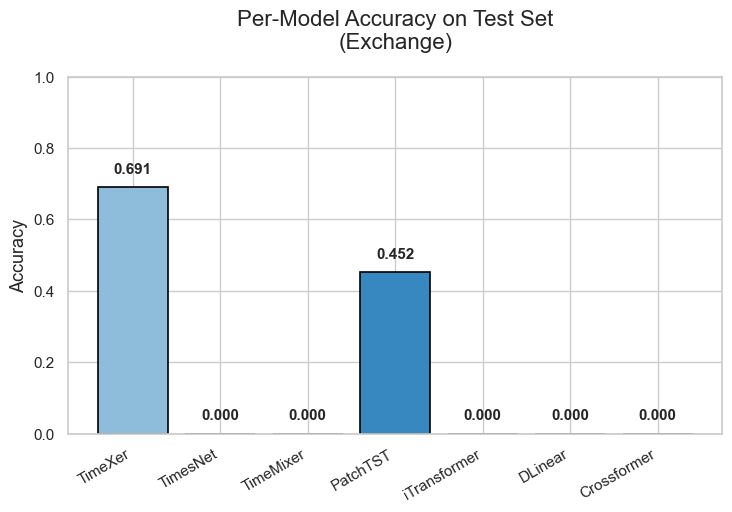

/Users/eiriksteen/miniconda3/envs/mcs/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Dataset ili: Train=(67, 96, 7), Val=(15, 96, 7), Test=(15, 96, 7)

PER-DATASET EVALUATION

Dataset: ili | Test Accuracy: 0.1333
              precision    recall  f1-score   support

     TimeXer       0.00      0.00      0.00         0
    TimesNet       0.00      0.00      0.00         0
   TimeMixer       0.00      0.00      0.00         4
    PatchTST       0.67      0.18      0.29        11
iTransformer       0.00      0.00      0.00         0
     DLinear       0.00      0.00      0.00         0
 Crossformer       0.00      0.00      0.00         0

    accuracy                           0.13        15
   macro avg       0.10      0.03      0.04        15
weighted avg       0.49      0.13      0.21        15


AGGREGATE EVALUATION
Aggregate Test Accuracy: 0.1333
Saved: plots/accuracy_ili.png


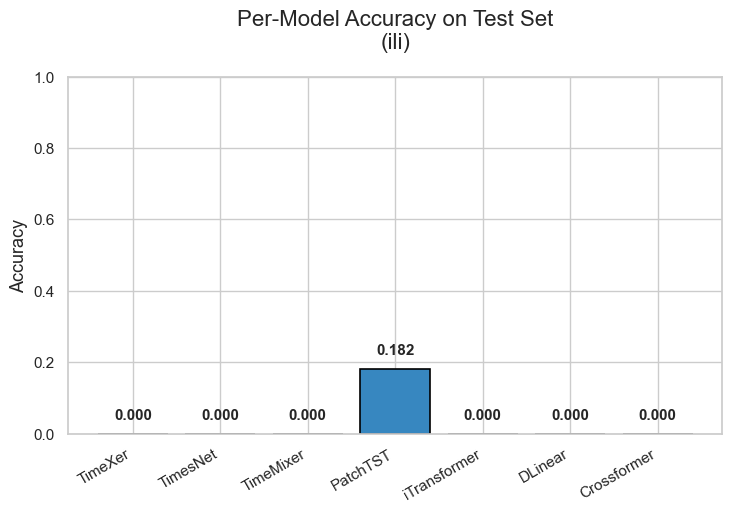

Dataset weather: Train=(7310, 96, 21), Val=(1566, 96, 21), Test=(1567, 96, 21)

PER-DATASET EVALUATION

Dataset: weather | Test Accuracy: 0.2859
              precision    recall  f1-score   support

     TimeXer       0.39      0.41      0.40       573
    TimesNet       0.50      0.36      0.42       319
   TimeMixer       0.07      0.04      0.05       194
    PatchTST       0.00      0.00      0.00        36
iTransformer       0.08      0.14      0.10       131
     DLinear       0.18      0.24      0.20        88
 Crossformer       0.17      0.22      0.19       226

    accuracy                           0.29      1567
   macro avg       0.20      0.20      0.20      1567
weighted avg       0.30      0.29      0.29      1567


AGGREGATE EVALUATION
Aggregate Test Accuracy: 0.2859
Saved: plots/accuracy_weather.png


/Users/eiriksteen/miniconda3/envs/mcs/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


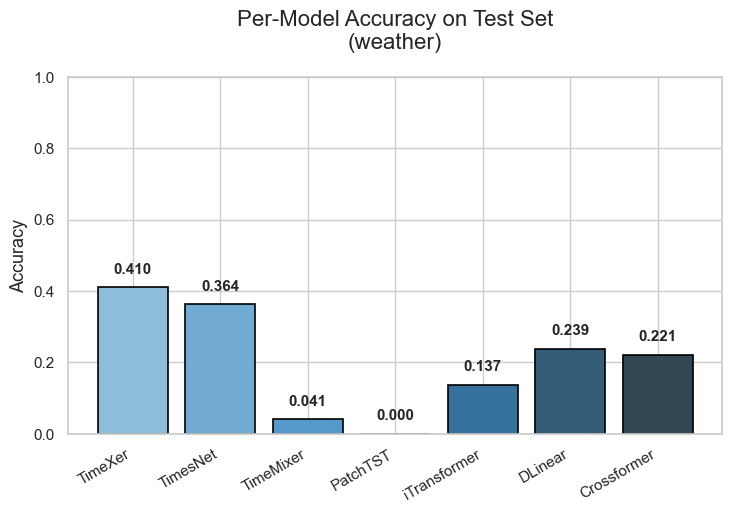

Dataset ETTh1: Train=(1948, 96, 7), Val=(418, 96, 7), Test=(418, 96, 7)

PER-DATASET EVALUATION

Dataset: ETTh1 | Test Accuracy: 0.1507
              precision    recall  f1-score   support

     TimeXer       0.18      0.22      0.20        68
    TimesNet       0.08      0.21      0.11        34
   TimeMixer       0.32      0.22      0.26        73
    PatchTST       0.00      0.00      0.00        37
iTransformer       0.10      0.65      0.18        20
     DLinear       0.17      0.01      0.02       112
 Crossformer       0.31      0.15      0.20        74

    accuracy                           0.15       418
   macro avg       0.17      0.21      0.14       418
weighted avg       0.20      0.15      0.14       418


AGGREGATE EVALUATION
Aggregate Test Accuracy: 0.1507
Saved: plots/accuracy_etth1.png


/Users/eiriksteen/miniconda3/envs/mcs/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


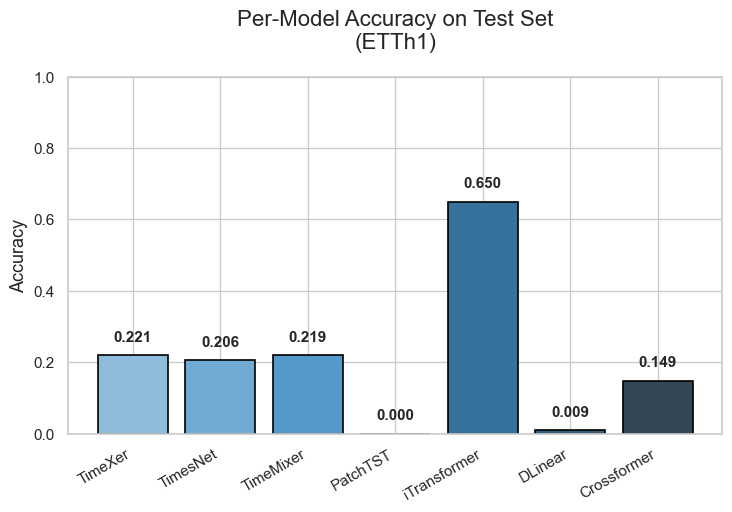

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [273]:
train_and_evaluate_classifier(
    log_reg, [classification_data['Exchange']], {0: "Exchange"})
train_and_evaluate_classifier(log_reg, [classification_data['ili']], {0: "ili"})
train_and_evaluate_classifier(
    log_reg, [classification_data['weather']], {0: "weather"})
train_and_evaluate_classifier(
    log_reg, [classification_data['ETTh1']], {0: "ETTh1"})

Dataset Exchange: Train=(994, 96, 8), Val=(213, 96, 8), Test=(214, 96, 8)

PER-DATASET EVALUATION

Dataset: Exchange | Test Accuracy: 0.1729
              precision    recall  f1-score   support

     TimeXer       0.20      0.33      0.25        55
    TimesNet       0.00      0.00      0.00        16
   TimeMixer       0.00      0.00      0.00        32
    PatchTST       0.40      0.31      0.35        62
iTransformer       0.00      0.00      0.00        27
     DLinear       0.00      0.00      0.00        22
 Crossformer       0.00      0.00      0.00         0

    accuracy                           0.17       214
   macro avg       0.09      0.09      0.09       214
weighted avg       0.17      0.17      0.16       214


AGGREGATE EVALUATION
Aggregate Test Accuracy: 0.1729
Saved: plots/accuracy_exchange.png


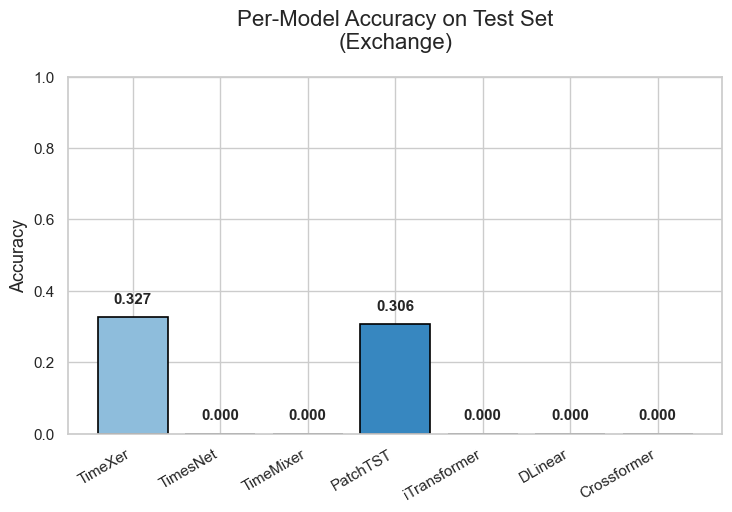

Dataset ili: Train=(67, 96, 7), Val=(15, 96, 7), Test=(15, 96, 7)

PER-DATASET EVALUATION

Dataset: ili | Test Accuracy: 0.7333
              precision    recall  f1-score   support

     TimeXer       0.00      0.00      0.00         0
    TimesNet       0.00      0.00      0.00         0
   TimeMixer       0.00      0.00      0.00         4
    PatchTST       0.73      1.00      0.85        11
iTransformer       0.00      0.00      0.00         0
     DLinear       0.00      0.00      0.00         0
 Crossformer       0.00      0.00      0.00         0

    accuracy                           0.73        15
   macro avg       0.10      0.14      0.12        15
weighted avg       0.54      0.73      0.62        15


AGGREGATE EVALUATION
Aggregate Test Accuracy: 0.7333
Saved: plots/accuracy_ili.png


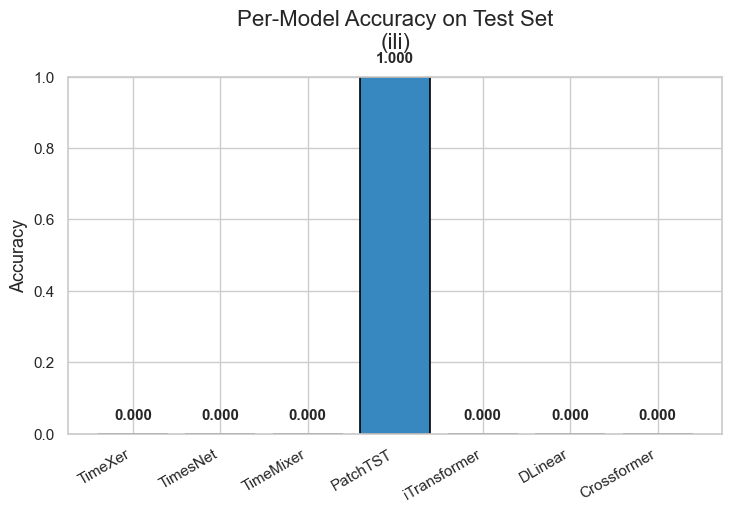

Dataset weather: Train=(7310, 96, 21), Val=(1566, 96, 21), Test=(1567, 96, 21)

PER-DATASET EVALUATION

Dataset: weather | Test Accuracy: 0.2802
              precision    recall  f1-score   support

     TimeXer       0.42      0.54      0.47       573
    TimesNet       0.26      0.17      0.20       319
   TimeMixer       0.17      0.07      0.10       194
    PatchTST       0.00      0.00      0.00        36
iTransformer       0.06      0.05      0.05       131
     DLinear       0.18      0.43      0.25        88
 Crossformer       0.10      0.08      0.09       226

    accuracy                           0.28      1567
   macro avg       0.17      0.19      0.17      1567
weighted avg       0.26      0.28      0.26      1567


AGGREGATE EVALUATION
Aggregate Test Accuracy: 0.2802
Saved: plots/accuracy_weather.png


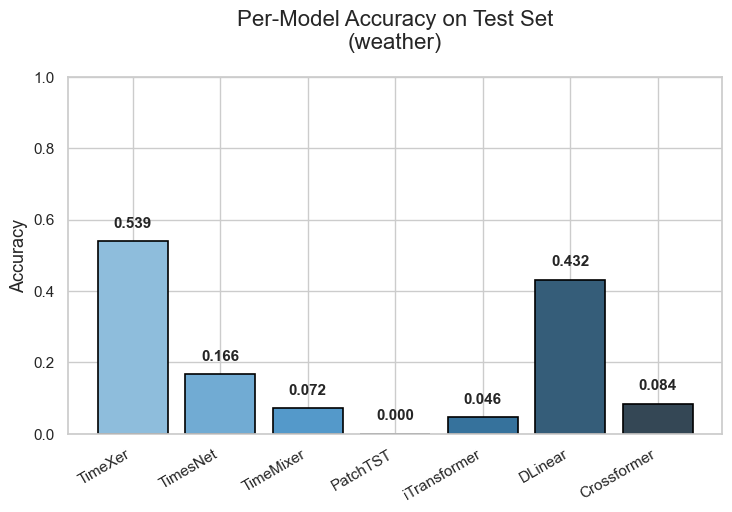

Dataset ETTh1: Train=(1948, 96, 7), Val=(418, 96, 7), Test=(418, 96, 7)

PER-DATASET EVALUATION

Dataset: ETTh1 | Test Accuracy: 0.1316
              precision    recall  f1-score   support

     TimeXer       0.14      0.15      0.14        68
    TimesNet       0.19      0.12      0.15        34
   TimeMixer       0.14      0.48      0.22        73
    PatchTST       0.05      0.05      0.05        37
iTransformer       0.00      0.00      0.00        20
     DLinear       0.00      0.00      0.00       112
 Crossformer       0.25      0.05      0.09        74

    accuracy                           0.13       418
   macro avg       0.11      0.12      0.09       418
weighted avg       0.11      0.13      0.09       418


AGGREGATE EVALUATION
Aggregate Test Accuracy: 0.1316
Saved: plots/accuracy_etth1.png


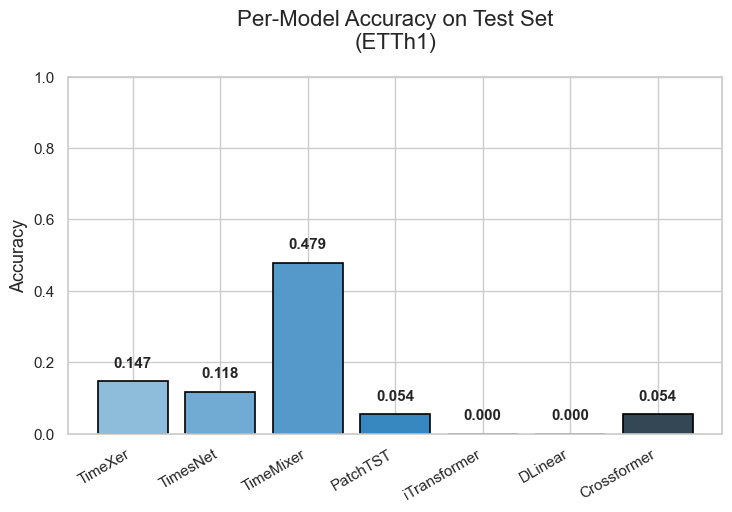

RocketClassifier(n_jobs=-1, num_kernels=100)

In [274]:
train_and_evaluate_classifier(
    rocket, [classification_data['Exchange']], {0: "Exchange"})
train_and_evaluate_classifier(rocket, [classification_data['ili']], {0: "ili"})
train_and_evaluate_classifier(
    rocket, [classification_data['weather']], {0: "weather"})
train_and_evaluate_classifier(
    rocket, [classification_data['ETTh1']], {0: "ETTh1"})

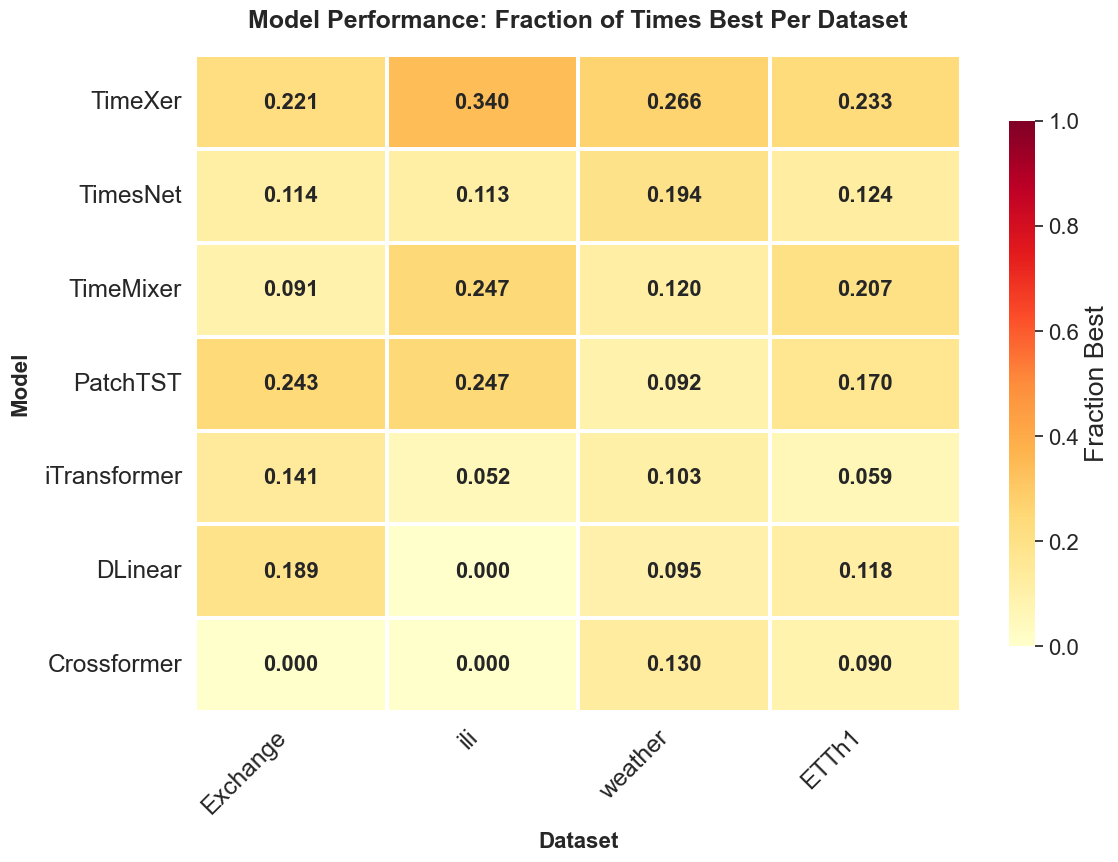

In [275]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.6)

# Create a matrix: rows=models, cols=datasets, values=fraction of times best
model_names = classification_data['Exchange'].model_names
dataset_names = list(classification_data.keys())

# Calculate fractions (0 to 1)
best_fractions = np.zeros((len(model_names), len(dataset_names)))

for j, dataset_name in enumerate(dataset_names):
    clf_data = classification_data[dataset_name]
    n_samples = clf_data.labels.shape[0]
    for i, model_name in enumerate(model_names):
        best_fractions[i, j] = clf_data.labels[:, i].sum() / n_samples

# Create heatmap with improved styling
fig, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(best_fractions, 
            annot=True, 
            fmt='.3f',
            cmap='YlOrRd',
            xticklabels=dataset_names,
            yticklabels=model_names,
            cbar_kws={'label': 'Fraction Best', 'shrink': 0.8},
            linewidths=1.5,
            linecolor='white',
            vmin=0,
            vmax=1.0,  # Fixed at 1.0 so darkest color always represents 100%
            square=False,
            ax=ax,
            annot_kws={'size': 16, 'weight': 'bold'})

# Styling improvements
ax.set_title('Model Performance: Fraction of Times Best Per Dataset', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Dataset', fontsize=16, fontweight='bold', labelpad=10)
ax.set_ylabel('Model', fontsize=16, fontweight='bold', labelpad=10)

# Rotate labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)

plt.tight_layout()
plt.show()


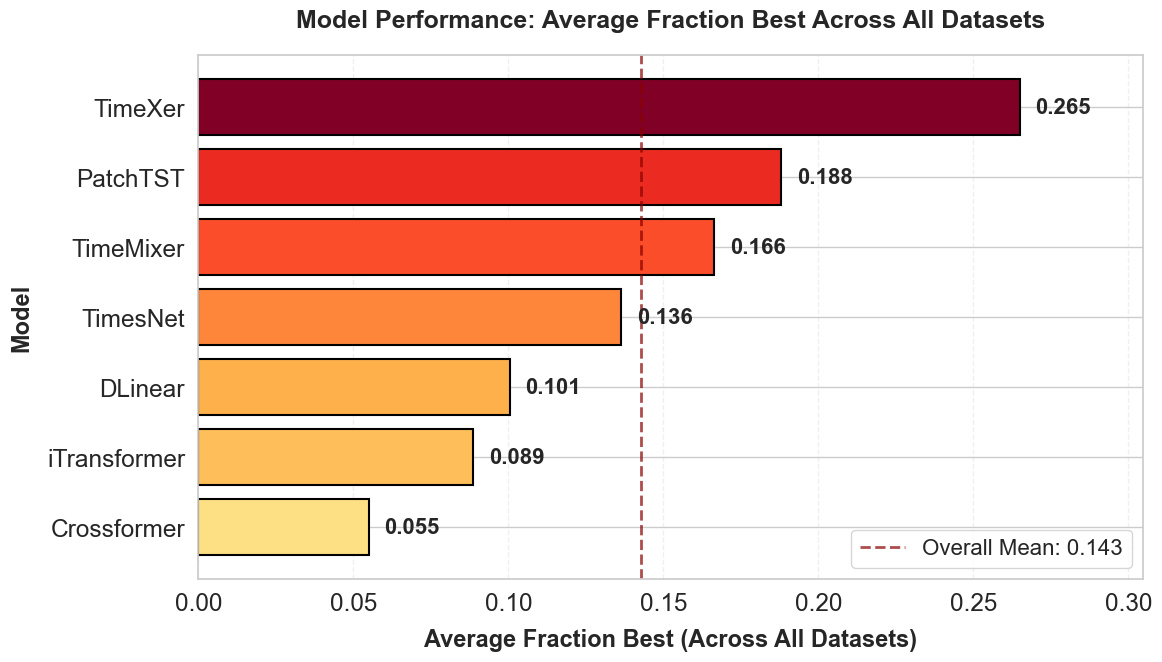


Model Performance Summary (Average Fraction Best):
TimeXer        : 0.2649
PatchTST       : 0.1880
TimeMixer      : 0.1664
TimesNet       : 0.1364
DLinear        : 0.1006
iTransformer   : 0.0887
Crossformer    : 0.0549
Mean           : 0.1429
Std Dev        : 0.0655


In [276]:
# Calculate average performance across all datasets for each model
avg_performance = best_fractions.mean(axis=1)  # Average across columns (datasets)

# Sort models by performance (best to worst)
sorted_indices = np.argsort(avg_performance)  # Ascending order
sorted_model_names = [model_names[i] for i in sorted_indices]
sorted_avg_performance = avg_performance[sorted_indices]

# Create bar plot
fig, ax = plt.subplots(figsize=(12, 7))

# Create bars with gradient colors based on performance
colors = plt.cm.YlOrRd(sorted_avg_performance / sorted_avg_performance.max())
bars = ax.barh(sorted_model_names, sorted_avg_performance, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, sorted_avg_performance)):
    ax.text(val + 0.005, i, f'{val:.3f}', 
            va='center', ha='left', fontweight='bold', fontsize=16)

# Styling
ax.set_xlabel('Average Fraction Best (Across All Datasets)', fontsize=17, fontweight='bold', labelpad=10)
ax.set_ylabel('Model', fontsize=17, fontweight='bold', labelpad=10)
ax.set_title('Model Performance: Average Fraction Best Across All Datasets', 
             fontsize=18, fontweight='bold', pad=20)

# Set x-axis limits and grid
ax.set_xlim(0, max(sorted_avg_performance) * 1.15)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Add vertical line at the mean
overall_mean = avg_performance.mean()
ax.axvline(overall_mean, color='darkred', linestyle='--', linewidth=2, alpha=0.7, 
           label=f'Overall Mean: {overall_mean:.3f}')
ax.legend(loc='lower right', fontsize=16)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nModel Performance Summary (Average Fraction Best):")
print("=" * 50)
for model, score in sorted(zip(model_names, avg_performance), key=lambda x: x[1], reverse=True):
    print(f"{model:15s}: {score:.4f}")
print("=" * 50)
print(f"{'Mean':15s}: {avg_performance.mean():.4f}")
print(f"{'Std Dev':15s}: {avg_performance.std():.4f}")


(1421, 7) 0
(1421, 7) 1
(1421, 7) 2
(1421, 7) 3
(1421, 7) 4
(1421, 7) 5
(1421, 7) 6
(1421, 7) 7
(1421, 7) 8
(1421, 7) 9
(1421, 7) 10
(1421, 7) 11
(1421, 7) 12
(1421, 7) 13
(1421, 7) 14
(1421, 7) 15
(1421, 7) 16
(1421, 7) 17
(1421, 7) 18
(1421, 7) 19
(1421, 7) 20
(1421, 7) 21
(1421, 7) 22
(1421, 7) 23
(1421, 7) 24
(1421, 7) 25
(1421, 7) 26
(1421, 7) 27
(1421, 7) 28
(1421, 7) 29
(1421, 7) 30
(1421, 7) 31
(1421, 7) 32
(1421, 7) 33
(1421, 7) 34
(1421, 7) 35
(1421, 7) 36
(1421, 7) 37
(1421, 7) 38
(1421, 7) 39
(1421, 7) 40
(1421, 7) 41
(1421, 7) 42
(1421, 7) 43
(1421, 7) 44
(1421, 7) 45
(1421, 7) 46
(1421, 7) 47
(1421, 7) 48
(1421, 7) 49
(1421, 7) 50
(1421, 7) 51
(1421, 7) 52
(1421, 7) 53
(1421, 7) 54
(1421, 7) 55
(1421, 7) 56
(1421, 7) 57
(1421, 7) 58
(1421, 7) 59
(1421, 7) 60
(1421, 7) 61
(1421, 7) 62
(1421, 7) 63
(1421, 7) 64
(1421, 7) 65
(1421, 7) 66
(1421, 7) 67
(1421, 7) 68
(1421, 7) 69
(1421, 7) 70
(1421, 7) 71
(1421, 7) 72
(1421, 7) 73
(1421, 7) 74
(1421, 7) 75
(1421, 7) 76
(1421, 7)

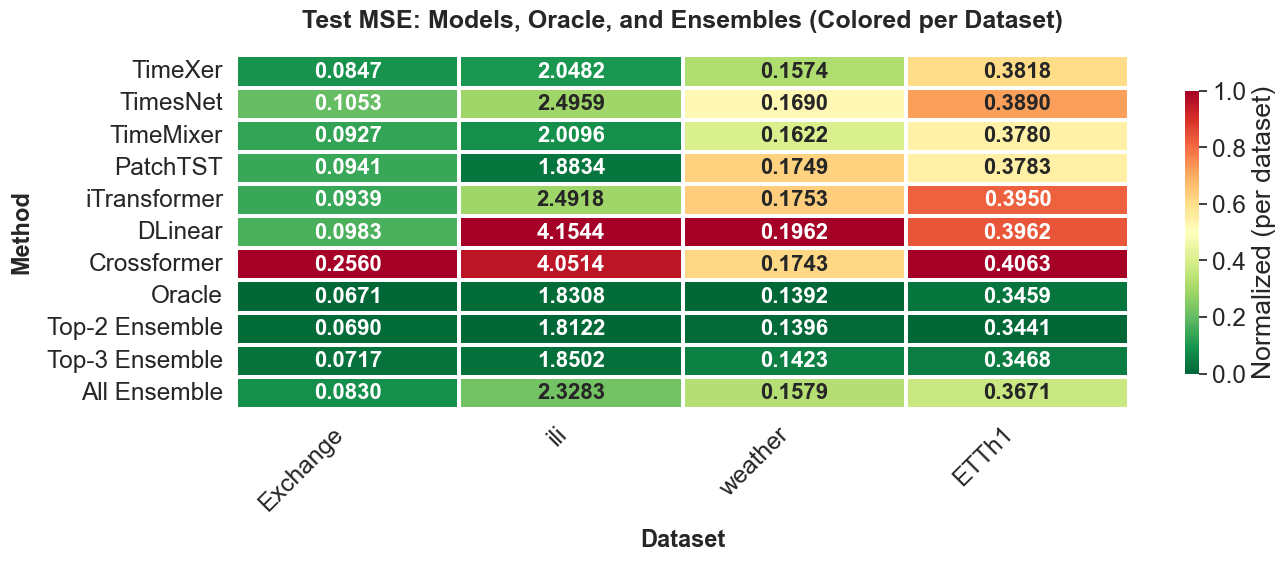

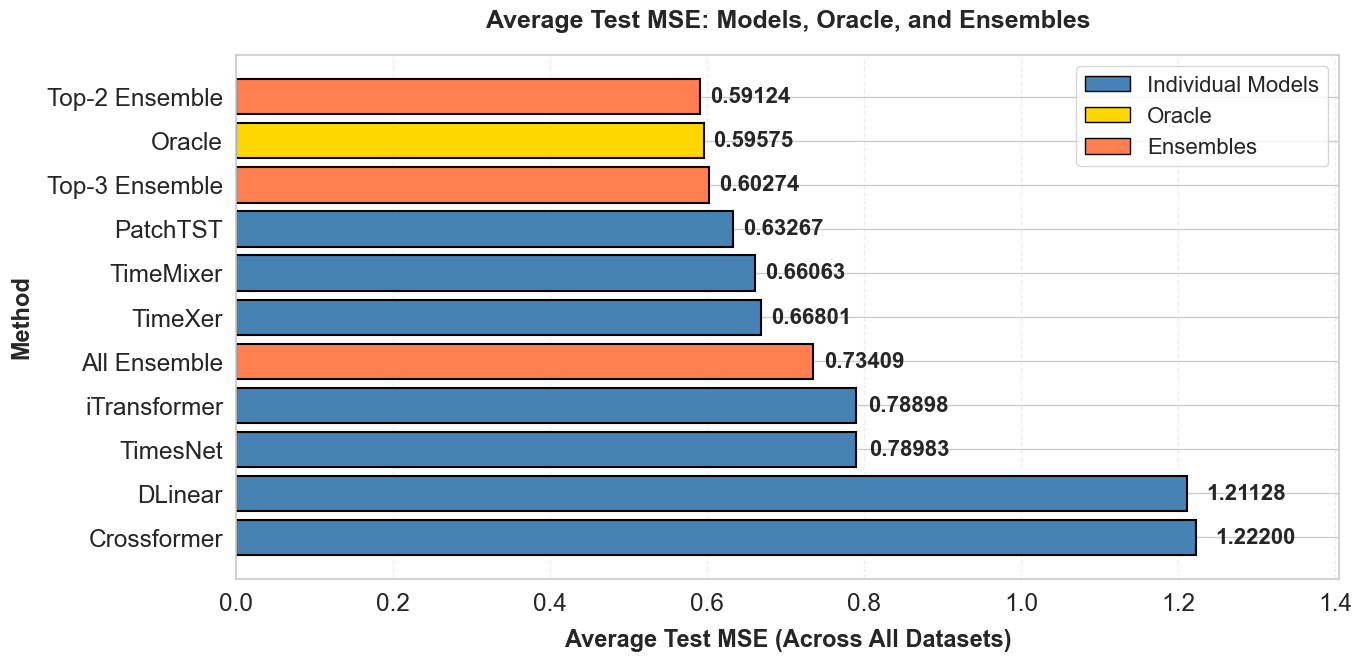

In [277]:
# Compute test MSE for each model + oracle + ensembles
import pandas as pd

results_summary = []

for dataset_name in dataset_names:
    data = all_data[dataset_name]
    clf_data = classification_data[dataset_name]
    gt = data.ground_truth
    n_samples = clf_data.mse.shape[0]
    
    row = {'Dataset': dataset_name}
    
    # Individual model MSEs (average over all samples)
    for i, model_name in enumerate(clf_data.model_names):
        preds = getattr(data, f"{model_name}_preds")
        if preds is not None:
            mse = ((preds - gt) ** 2).mean()
            row[model_name] = mse
        else:
            row[model_name] = np.nan
    
    # Oracle: for each sample, pick the prediction from the best model
    oracle_preds = np.zeros_like(gt)
    for sample_idx in range(n_samples):
        # Find which model(s) are best for this sample
        print(clf_data.mse.shape, sample_idx)
        best_model_idx = np.argmin(clf_data.mse[sample_idx])
        best_model_name = clf_data.model_names[best_model_idx]
        best_preds = getattr(data, f"{best_model_name}_preds")
        oracle_preds[sample_idx] = best_preds[sample_idx]
    
    oracle_mse = ((oracle_preds - gt) ** 2).mean()
    row['Oracle'] = oracle_mse
    
    # Top-K ensembles: average predictions from top K models per sample
    for top_k in [2, 3]:
        ensemble_preds = np.zeros_like(gt)
        
        for sample_idx in range(n_samples):
            # Get indices of top K models (lowest MSE) for this sample
            top_k_indices = np.argsort(clf_data.mse[sample_idx])[:top_k]
            
            # Average their predictions
            sample_preds = []
            for model_idx in top_k_indices:
                model_name = clf_data.model_names[model_idx]
                preds = getattr(data, f"{model_name}_preds")
                sample_preds.append(preds[sample_idx])
            
            ensemble_preds[sample_idx] = np.mean(sample_preds, axis=0)
        
        ensemble_mse = ((ensemble_preds - gt) ** 2).mean()
        row[f'Top-{top_k} Ensemble'] = ensemble_mse
    
    # All Ensemble: average predictions from all models
    all_ensemble_preds = np.zeros_like(gt)
    for sample_idx in range(n_samples):
        sample_preds = []
        for model_name in clf_data.model_names:
            preds = getattr(data, f"{model_name}_preds")
            if preds is not None:
                sample_preds.append(preds[sample_idx])
        all_ensemble_preds[sample_idx] = np.mean(sample_preds, axis=0)
    
    all_ensemble_mse = ((all_ensemble_preds - gt) ** 2).mean()
    row['All Ensemble'] = all_ensemble_mse
    
    results_summary.append(row)

# Create DataFrame
results_df = pd.DataFrame(results_summary)

# Reorder columns: Dataset, models, Oracle, ensembles
model_cols = clf_data.model_names
other_cols = ['Oracle', 'Top-2 Ensemble', 'Top-3 Ensemble', 'All Ensemble']
results_df = results_df[['Dataset'] + model_cols + other_cols]

print("\nTest MSE Results:")
print("=" * 120)
print(results_df.to_string(index=False))
print("=" * 120)

# Compute averages across datasets
avg_row = results_df[model_cols + other_cols].mean()
print(f"\nAverage MSE across all datasets:")
print("-" * 50)
for col in model_cols + other_cols:
    print(f"{col:20s}: {avg_row[col]:.6f}")
print("-" * 50)

# Find best individual model and compare to oracle/ensembles
best_individual_model = avg_row[model_cols].idxmin()
best_individual_mse = avg_row[model_cols].min()
oracle_mse_avg = avg_row['Oracle']
best_ensemble = avg_row[other_cols].idxmin()
best_ensemble_mse = avg_row[other_cols].min()

print(f"\nBest individual model: {best_individual_model} (MSE: {best_individual_mse:.6f})")
print(f"Oracle MSE: {oracle_mse_avg:.6f} (Improvement: {(best_individual_mse - oracle_mse_avg) / best_individual_mse * 100:.2f}%)")
print(f"Best ensemble: {best_ensemble} (MSE: {best_ensemble_mse:.6f})")
print(f"Best overall: {avg_row.idxmin()} (MSE: {avg_row.min():.6f})")

# Visualize with heatmap - normalize per dataset (column)
fig, ax = plt.subplots(figsize=(14, 6))

# Prepare data for heatmap (transpose so datasets are columns, methods are rows)
heatmap_data = results_df.set_index('Dataset')[model_cols + other_cols].T

# Normalize each column (dataset) independently for better color scaling
normalized_data = heatmap_data.copy()
for col in heatmap_data.columns:
    col_data = heatmap_data[col]
    min_val = col_data.min()
    max_val = col_data.max()
    if max_val > min_val:
        normalized_data[col] = (col_data - min_val) / (max_val - min_val)
    else:
        normalized_data[col] = 0.5

# Create heatmap with normalized colors but show original values
sns.heatmap(normalized_data, 
            annot=heatmap_data.values,  # Show original MSE values
            fmt='.4f',
            cmap='RdYlGn_r',  # Reverse so red=high MSE (bad), green=low MSE (good)
            xticklabels=dataset_names,
            yticklabels=model_cols + other_cols,
            cbar_kws={'label': 'Normalized (per dataset)', 'shrink': 0.8},
            linewidths=1.5,
            linecolor='white',
            vmin=0,
            vmax=1,
            ax=ax,
            annot_kws={'size': 16, 'weight': 'bold'})

ax.set_title('Test MSE: Models, Oracle, and Ensembles (Colored per Dataset)', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Dataset', fontsize=17, fontweight='bold', labelpad=10)
ax.set_ylabel('Method', fontsize=17, fontweight='bold', labelpad=10)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# Bar chart for average MSE
fig, ax = plt.subplots(figsize=(14, 7))

# Sort by average MSE (reversed: best at top, worst at bottom)
all_methods = model_cols + other_cols
sorted_indices = np.argsort(avg_row[all_methods].values)[::-1]  # Reverse order
sorted_methods = [all_methods[i] for i in sorted_indices]
sorted_values = avg_row[all_methods].values[sorted_indices]

# Color code: models vs oracle/ensembles
colors_list = []
for method in sorted_methods:
    if method in model_cols:
        colors_list.append('steelblue')
    elif method == 'Oracle':
        colors_list.append('gold')
    elif 'Ensemble' in method:
        colors_list.append('coral')
    else:
        colors_list.append('gray')

bars = ax.barh(sorted_methods, sorted_values, color=colors_list, edgecolor='black', linewidth=1.5)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, sorted_values)):
    ax.text(val + val * 0.02, i, f'{val:.5f}', 
            va='center', ha='left', fontweight='bold', fontsize=16)

# Styling
ax.set_xlabel('Average Test MSE (Across All Datasets)', fontsize=17, fontweight='bold', labelpad=10)
ax.set_ylabel('Method', fontsize=17, fontweight='bold', labelpad=10)
ax.set_title('Average Test MSE: Models, Oracle, and Ensembles', 
             fontsize=18, fontweight='bold', pad=20)

ax.set_xlim(0, max(sorted_values) * 1.15)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', edgecolor='black', label='Individual Models'),
    Patch(facecolor='gold', edgecolor='black', label='Oracle'),
    Patch(facecolor='coral', edgecolor='black', label='Ensembles')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=16)

plt.tight_layout()
plt.show()
